In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

In [2]:
source_directory = f"D:/Courses/Uclouvain/thesis/code/these_Colin/seismogram_curve_extraction/data/ground_truths/overlap_20_images/"

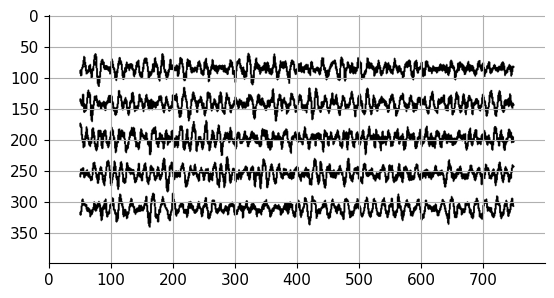

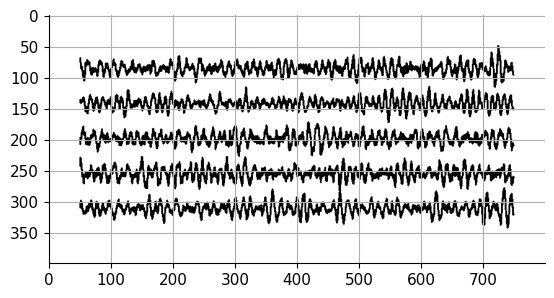

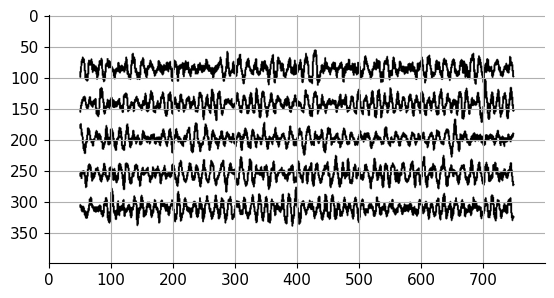

In [3]:
def load_images_from_folder(folder, N_show):
    # set N_show to 0 not to show any images
    saved_images = []  # List to store images
    count = 0
    for image_file in os.listdir(folder):
        if image_file.endswith('_binary.jpg'):
            image_file = os.path.join(folder, image_file)
            saved_images.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
            if count < N_show:
                plt.imshow(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE), cmap='gray')
                plt.show()
                count += 1

    return np.array(saved_images)

saved_images = load_images_from_folder(source_directory, 3)


In [4]:
# Get the ROI of the images
def get_roi(image):
    temp_image = - (image - np.max(image))
    # Get the row and column indices of the non-zero elements
    rows, cols = np.nonzero(temp_image)
    # Get the minimum and maximum row and column indices
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    # Get the ROI of the image
    roi = image[min_row:max_row + 1, min_col:max_col + 1]
    return roi

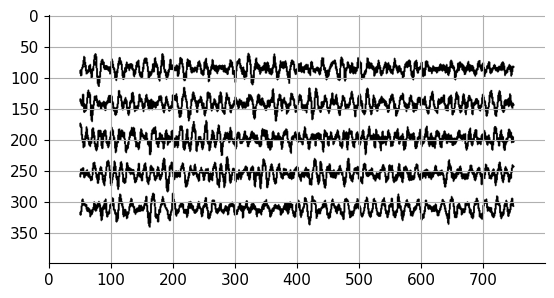

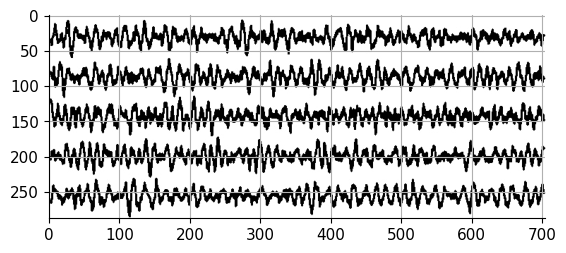

In [5]:
plt.imshow(saved_images[0], cmap='gray')
plt.show()

# Get the ROI of all the images
new_saved_images = []
for image in saved_images:
    new_saved_images.append(np.array(get_roi(image)))

saved_images = new_saved_images

plt.imshow(saved_images[0], cmap='gray')
plt.show()

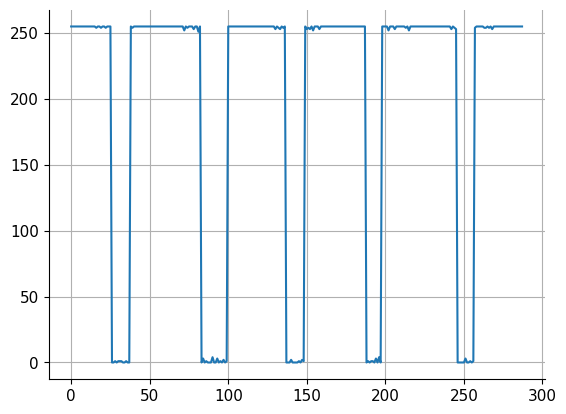

In [6]:
# plot one column of the image
plt.plot(saved_images[0][:, len(saved_images[0][0])//2])
plt.show()

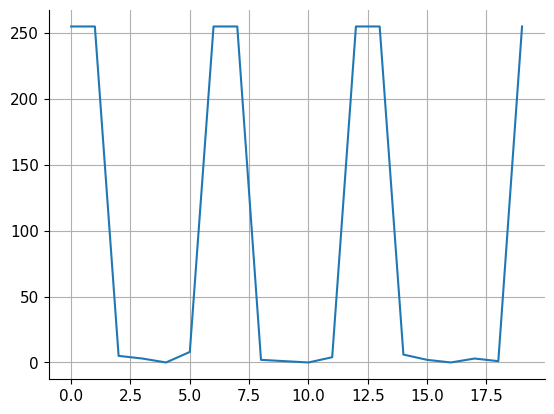

Number of connected components: 3
Average thickness: 4.333333333333333


In [7]:
def count_components_and_avg_thickness(arr, threshold=10):
    """
    Counts the number of connected components where values are close to 0 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing grayscale values (0 to 255).
    - threshold: Defines what is considered "close to 0" (default: 10).

    Returns:
    - count: Number of connected components.
    - avg_thickness: Average thickness of components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] < threshold:  # Found a new component (close to 0)
            count += 1
            start = i
            while i < n and arr[i] < threshold:  # Continue until background (255)
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# Example usage
binary_array = np.array([255, 255, 5, 3, 0, 8, 255, 255, 2, 1, 0, 4, 255, 255, 6, 2, 0, 3, 1, 255])
num_components, avg_thickness = count_components_and_avg_thickness(binary_array)

plt.plot(binary_array)
plt.show()

print(f"Number of connected components: {num_components}")
print(f"Average thickness: {avg_thickness}")


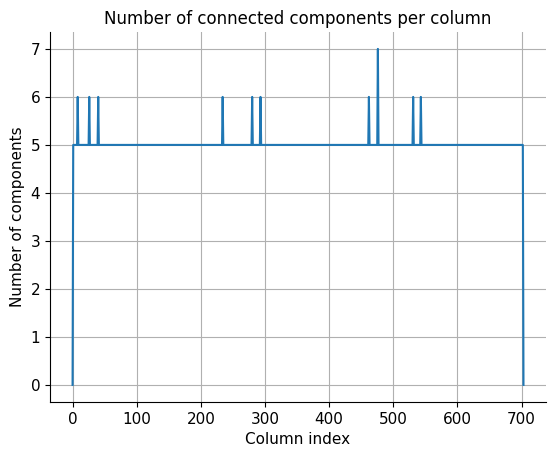

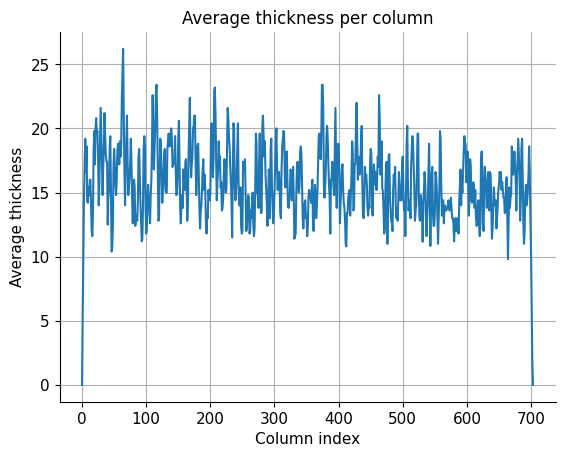

Average number of components: 5 VS true value is 5
Average thickness: 15 VS true value is 15


In [8]:
# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(saved_images[0].shape[1]):
    n, t = count_components_and_avg_thickness(saved_images[0][:, i])
    N_components.append(n)
    thickness.append(t)

plt.plot(N_components)
plt.title("Number of connected components per column")
plt.xlabel("Column index")
plt.ylabel("Number of components")
plt.show()

plt.plot(thickness)
plt.title("Average thickness per column")
plt.xlabel("Column index")
plt.ylabel("Average thickness")
plt.show()

# compute the average thickness and number of components for all images by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 1e-6]
thickness = thickness[thickness > 1e-6]

avg_N_components = int(np.mean(N_components))
avg_thickness = int(np.mean(thickness))
print(f"Average number of components: {int(np.mean(N_components))} VS true value is 5")
print(f"Average thickness: {int(np.mean(thickness))} VS true value is 15")


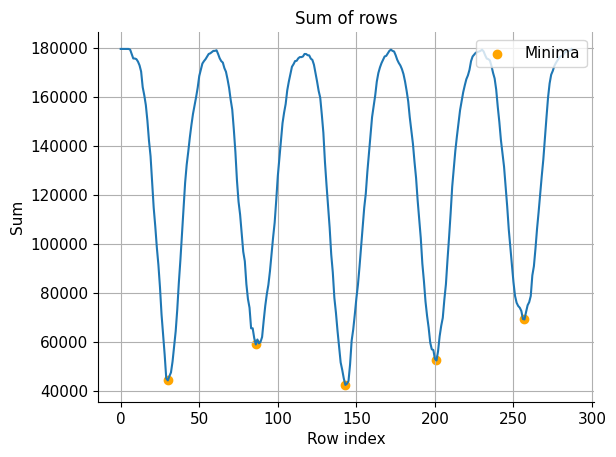

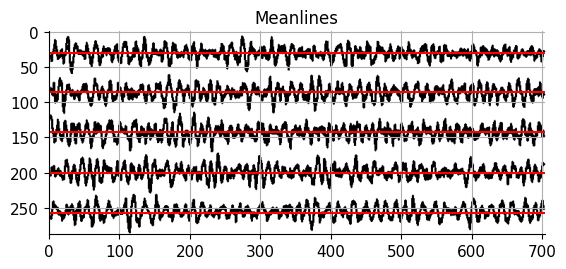

In [9]:
# find the meanlines of each curves in the image
# sum the rows of the image
sum_rows = np.sum(saved_images[0], axis=1)

# Find local minima
min_indices = argrelextrema(sum_rows, np.less, order=10)[0]
sorted_minima = min_indices[np.argsort(sum_rows[min_indices])]

plt.plot(sum_rows)
plt.scatter(sorted_minima[:avg_N_components], sum_rows[sorted_minima[:avg_N_components]], color='orange', label="Minima")
plt.legend()
plt.title("Sum of rows")
plt.xlabel("Row index")
plt.ylabel("Sum")
plt.show()

# The meanlines are the num_components rows with the minimum sum
meanlines = sorted_minima[:avg_N_components]

plt.imshow(saved_images[0], cmap='gray')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.show()

In [10]:
# Find the starting point of each component
starting_points = []

# iterate over the columns of the image until

In [11]:
# Implement the Kalman Filter to track the curves around the meanlines

# Define the prediction step
def predict(X, P, A, Q):
    # check if X has 1 or 2 dimension(s)
    if len(X.shape) == 1:
        X = A @ X
        P = A @ P @ A.T + Q
    else:
        for i in range(X.shape[0]):
            X[i] = A @ X[i]
            P[i] = A @ P[i] @ A.T + Q
        # X = (A @ X.T).T  # Batch multiply all rows of X at once
        # P = A @ P @ A.T + Q  # Assuming P is (N, M, M), use batch multiplication
    return X, P

# Define the update step
def update(X, P, Z, H, R):
    """
    Perform the classical Kalman update step.
    In the classical update, the number of measurements must be equal to the number of states. 
    Moreover it is assumed that the measurements have been associated correctly to the states.
    
    Args:
        X (np.ndarray): Shape (n,) or (N, n)      - State estimate.
        P (np.ndarray): Shape (n, n) or (N, n, n) - Covariance matrix.
        Z (np.ndarray): Shape (m,) or (N, m)      - Measurement vector corresponding to this state.
        H (np.ndarray): Shape (m, n)              - Observation matrix.
        R (np.ndarray): Shape (m, m)              - Measurement noise covariance.

    Returns:
        X_updated (np.ndarray): Updated state(s) estimates.
        P_updated (np.ndarray): Updated covariance matrices.
    """
    if len(X.shape) == 1:
        if (H @ P @ H.T + R).shape[1] == (H @ P @ H.T + R).shape[1] == 1: K = (P @ H.T) / (H @ P @ H.T + R)
        else: K = np.linalg.solve(H @ P @ H.T + R, P @ H.T)
        X = X + K @ (Z - H @ X)
        P = P - K @ H @ P
    else:
        for i in range(X.shape[0]):
            if (H @ P @ H.T + R).shape[0] == (H @ P @ H.T + R).shape[1] == 1: K = (P @ H.T) / (H @ P @ H.T + R)
            else: K = np.linalg.solve(H @ P @ H.T + R, P @ H.T)            
            X[i] = X[i] + K @ (Z[i] - H @ X[i])
            P[i] = P[i] - K @ H @ P[i]
    return X, P

def  weighted_update(X, P, Z, H, R, P_fp=0):
    """
    Perform the Kalman filter update step using the JPDA approach for multiple traces.

    Args:
        X (np.ndarray): Shape (N, n, 1) - Predicted state estimates for N traces.
        P (np.ndarray): Shape (N, n, n) - Predicted covariance matrices for N traces.
        Z (np.ndarray): Shape (M, m, 1) - Measurements for M detections.
        H (np.ndarray): Shape (m, n) - Observation matrix.
        R (np.ndarray): Shape (m, m) - Measurement noise covariance.

    Returns:
        X_updated (np.ndarray): Shape (N, n, 1) - Updated state estimates.
        P_updated (np.ndarray): Shape (N, n, n) - Updated covariance matrices.
    """
    # print("X shape", X.shape)
    # print("P shape", P.shape)
    # print("Z shape", Z.shape)
    # print("H shape", H.shape)
    # print("R shape", R.shape)
    N, n = X.shape  # Number of traces, state dimension
    M = Z.shape[0]      # Number of measurements
    if N != M : print('merede')
    # m = Z.shape[1]      # Measurement dimension
    m = 1
    
    X_updated = np.copy(X)
    P_updated = np.copy(P)
    
    # Compute innovation covariance and Kalman gains
    S = np.zeros((N, m, m))  # Innovation covariance for each trace
    K = np.zeros((N, n, m))  # Kalman gain for each trace
    for i in range(N):
        S[i] = H @ P[i] @ H.T + R  # Innovation covariance
        if (S[i]).shape[0] == (S[i]).shape[1] == 1: K[i] = (P[i] @ H.T) / S[i]
        else: K[i] = np.linalg.solve(S[i], P[i] @ H.T)  
        # K[i] = P[i] @ H.T @ np.linalg.inv(S[i])  # Kalman gain
    # print("K shape", K.shape)
    # print("S shape", S.shape)

    # Compute association probabilities β_ij using Mahalanobis distance
    beta = np.zeros((N, M))
    likelihoods = np.zeros((N, M))

    for i in range(N):
        for j in range(M):
            residual = Z[j] - H @ X[i]  # Innovation (measurement residual)
            mahalanobis_dist = residual.T @ np.linalg.inv(S[i]) @ residual  # Mahalanobis distance
            likelihoods[i, j] = np.exp(-0.5 * mahalanobis_dist) / np.sqrt((2*np.pi)**m*np.linalg.det(S[i])**2)

    # Normalize probabilities
    for i in range(N):
        beta[i, :] = likelihoods[i, :] / (np.sum(likelihoods[i, :]) + P_fp)  # Avoid division by zero
    # print(beta.sum(axis=1), beta.shape)

    # Update states using weighted innovation
    # print("N",N)
    for i in range(N):
        # print(i)
        weighted_innovation = np.zeros((m, 1))
        for j in range(M):
            weighted_innovation += beta[i, j] * (Z[j] - H @ X[i])

        # Update state and covariance
        beta_i = np.sum(beta[i, :])
        # print(X[i])
        # print(K[i], "K", K.shape)
        # print(weighted_innovation)
        # print("tt", "K", K[i].shape, "weighted_innovation", weighted_innovation.shape, (K[i] @ weighted_innovation).shape)
        X_updated[i] = X[i] + (K[i] @ weighted_innovation).ravel()
        temp = (np.eye(n) - beta_i * K[i] @ H)
        P_updated[i] = temp @ P[i] @ temp.T + K[i] @ (np.sum(beta[i, :]**2) * R) @ K[i].T
    # print("X_updated shape", X_updated.shape)
    # print("P_updated shape", P_updated.shape)


    return X_updated, P_updated, beta

In [12]:
# Define the state transition matrix
Delta = 1 # Time step [pixels]
A = np.array([[1, Delta, Delta**2/2],
              [0, 1, Delta],
              [0, 0, 1]])   

H = np.array([[1, 0, 0]])

# Define the process noise covariance matrix
sigma_a = 0.1
Q = np.array([[0, 0, 0],
              [0, sigma_a**2, 0],
              [0, 0, 0]])

# Define the measurement noise covariance matrix
sigma_z = 1
R = np.array([[sigma_z**2]])

# Initialize the state and covariance
X = np.zeros((avg_N_components, 3))  # Initial state: [position, velocity, acceleration]
X[:, 0] = meanlines  # Initialize the positions to the meanlines
P = np.zeros((avg_N_components, 3, 3))  # Initial covariance
P[:, 0, 0] = 1  # Initialize the position covariance
P[:, 1, 1] = 1  # Initialize the velocity covariance
P[:, 2, 2] = 1  # Initialize the acceleration covariance

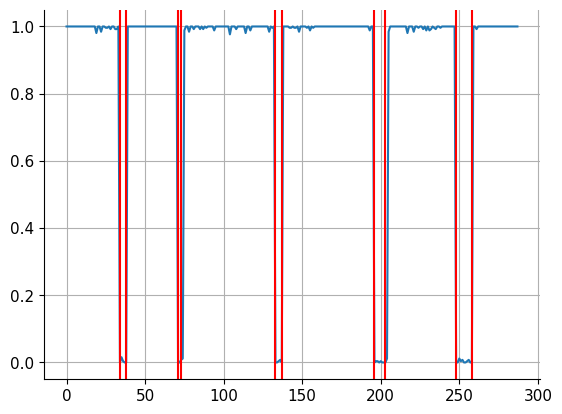

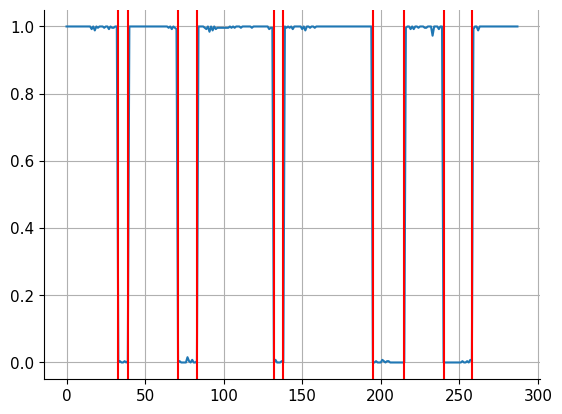

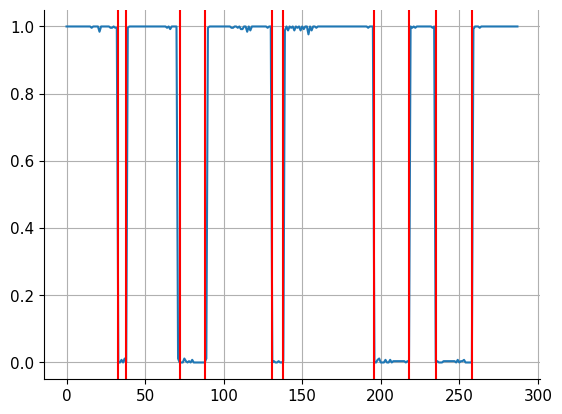

In [13]:
# Iterate over the columns of the image, 0 value pixels vertical position are the measurements
sel = 10
tresh = 1e-2
spacing = avg_thickness/2 # number of pixels
count = 0
positions = np.full((avg_N_components, 2), np.nan) # contains start and stop positions of each trace for each component
measurements = np.full((saved_images[sel].shape[1], avg_N_components), np.nan) # contains the position of the measurements for each component

for col_idx in range(saved_images[sel].shape[1]):
    col = saved_images[sel][:, col_idx].astype(np.float64)
    if col.max() - col.min() > 0: col /= col.max() - col.min()

    # find the 0 value pixels, with a given treshold
    temp = np.where(col < tresh)[0]
    if len(temp) == 0: continue

    val_prev = temp[0]
    i = 0
    positions[i, 0] = val_prev

    # print(measurements)

    for val in temp[1:]:
        if val - val_prev > spacing and i < avg_N_components:
            positions[i, 1] = val_prev
            i += 1
            if i < avg_N_components: positions[i, 0] = val
        val_prev = val
    positions[-1, 1] = val

    # print(positions)

    # plot the measurements
    if count < 3:
        plt.figure()
        plt.plot(col)
        # plot vertical lines at the positions of the measurements
        for pos in positions:
            plt.axvline(pos[0], color='r')
            plt.axvline(pos[1], color='r')
        plt.show
        # delete
        count += 1
    
    for i in range(avg_N_components):
        if not np.isnan(positions[i, 0]):
            measurements[col_idx, i] = (positions[i, 1] + positions[i, 0]) / 2
        
# measurements[col_idx, i] = positions[i, 1] 


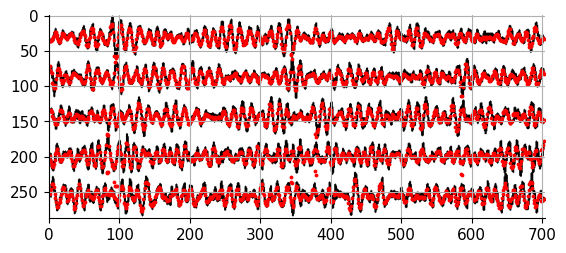

In [14]:
plt.imshow(saved_images[sel], cmap='gray')

# add white noise to the measurements
# sigma_noise = 5
# measurements += np.random.normal(0, sigma_noise, measurements.shape)

# Vectorized scatter plotting
for i in range(avg_N_components):
    valid_indices = ~np.isnan(measurements[:, i])  # Get valid (non-NaN) indices
    plt.scatter(np.where(valid_indices)[0], measurements[valid_indices, i], color='r', s=3)

plt.show()

In [15]:
# Now we can apply the Kalman filter to track the curves around the meanlines

# Initialize the list of estimated positions
estimated_positions_classic = [X[0, 0]]
estimated_positions_weighted = [X[0, 0]]

###
# Classical Kalman filter
###
X_classic = np.copy(X)
P_classic = np.copy(P)
for k in tqdm(range(1, saved_images[sel].shape[1]), desc="Processing columns"):
    # Predict
    X_c, P_c = predict(X_classic, P_classic, A, Q)

    # Classical Update
    for i in range(avg_N_components):
        if True:
            if not np.isnan(measurements[k, i]):            
                X_classic[i], P_classic[i] = update(X_c[i], P_c[i], measurements[k, i], H, R) # classical Kalman filter

    
    # Save the estimated position
    estimated_positions_classic.append(X_classic[0, 0])

Processing columns: 100%|██████████| 703/703 [00:00<00:00, 3680.65it/s]


In [16]:
### 
# Weighted Kalman filter
###
X_weighted = np.copy(X)
P_weighted = np.copy(P)
for k in tqdm(range(1, saved_images[sel].shape[1]), desc="Processing columns"):
    # Predict
    X_w, P_w = predict(X_weighted, P_weighted, A, Q)
    # Weighted Update
    X_weighted, P_weighted, beta = weighted_update(X_w, P_w, measurements[k, :], H, R)

    # Save the estimated position
    estimated_positions_weighted.append(X_weighted[0, 0])

Processing columns: 100%|██████████| 703/703 [00:00<00:00, 733.03it/s]


[143.0, 137.46153846153845, 134.6370784817783, 133.81612372560554, 135.1744495767354, 140.52594434095886, 144.73561363055572, 147.53895626329984, 152.7732794370758, 156.13790534593832, 157.58784040228548, 157.70490858281855, 154.74215567396757, 151.26076208567946, 148.30077249926325, 141.79866390141459, 136.70110040503377, 133.35683083270968, 131.9564400077721, 131.94711631334508, 134.793334754886, 138.59795724864227, 142.77315818272655, 146.48463870902998, 149.13598186657163, 150.12090911287999, 148.04132047952746, 145.07445924602314, 142.137297669696, 139.9210742394497, 138.9220858893096, 140.44822970356284, 143.3043299326836, 145.5448678754168, 147.02537309505155, 147.0970310273441, 146.26422155897927, 144.95761272953803, 142.95289573146067, 141.6135975777023, 140.84388178147591, 140.34717045372474, 141.20561419204418, 142.3360684365782, 143.43965924614923, 143.9099588880731, 143.29309568425677, 142.96965446130883, 143.08766213634354, 143.934385958651, 144.7714611166019, 145.3874530

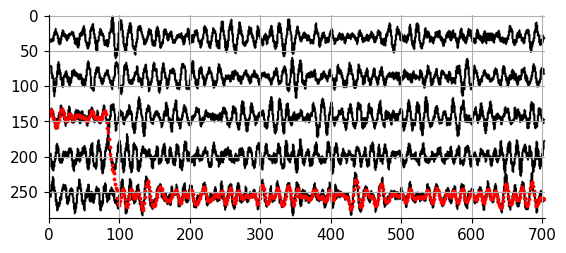

In [17]:
estimated_positions = estimated_positions_weighted
print(estimated_positions_weighted)
print()
print(estimated_positions_classic)

# Plot the estimated positions
plt.imshow(saved_images[sel], cmap='gray')

estimated_positions = np.array(estimated_positions)
print(estimated_positions.shape)
# for i in range(avg_N_components):
i = 0
if True:
    valid_indices = ~np.isnan(estimated_positions)  # Get valid (non-NaN) indices
    plt.scatter(np.where(valid_indices)[0], estimated_positions[valid_indices], color='r', s=3)

plt.show()